In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import yfinance as yf

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")

In [13]:
ticker = "AAPL"

df = yf.download(ticker, period="5y", interval="1d")

# Move Date index to a column
df.reset_index(inplace=True)

# Keep only useful columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Sort by date (safety)
df = df.sort_values('Date').reset_index(drop=True)

print("Data shape:", df.shape)

/tmp/ipython-input-4188366031.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed

Data shape: (1256, 6)


In [14]:
df.head()

Price,Date,Open,High,Low,Close,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2020-11-30,113.864721,117.758530,113.708965,115.889503,169410200
1,2020-12-01,117.797472,120.192164,116.824019,119.462074,127728200
2,2020-12-02,118.780651,120.094817,117.680652,119.812515,89004200
3,2020-12-03,120.240836,120.493935,118.965616,119.676239,78967600
4,2020-12-04,119.345262,119.598361,118.293931,119.004555,78260400


In [15]:
df.tail()

Price,Date,Open,High,Low,Close,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
1251,2025-11-21,265.950012,273.329987,265.670013,271.489990,59030800
1252,2025-11-24,270.899994,277.000000,270.899994,275.920013,65585800
1253,2025-11-25,275.269989,280.380005,275.250000,276.970001,46914200
1254,2025-11-26,276.959991,279.529999,276.630005,277.549988,33431400
1255,2025-11-28,277.260010,279.000000,275.989990,278.850006,20135600


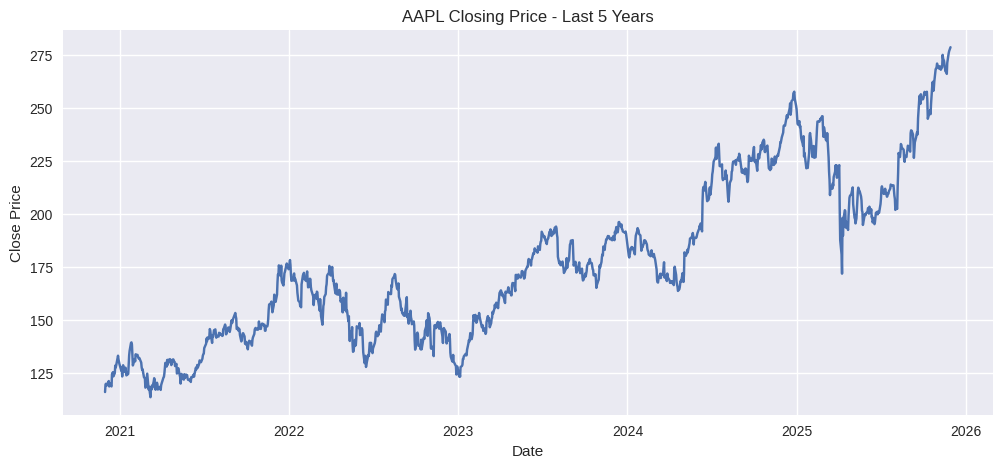

In [16]:
# Closing price over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'])
plt.title("AAPL Closing Price - Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

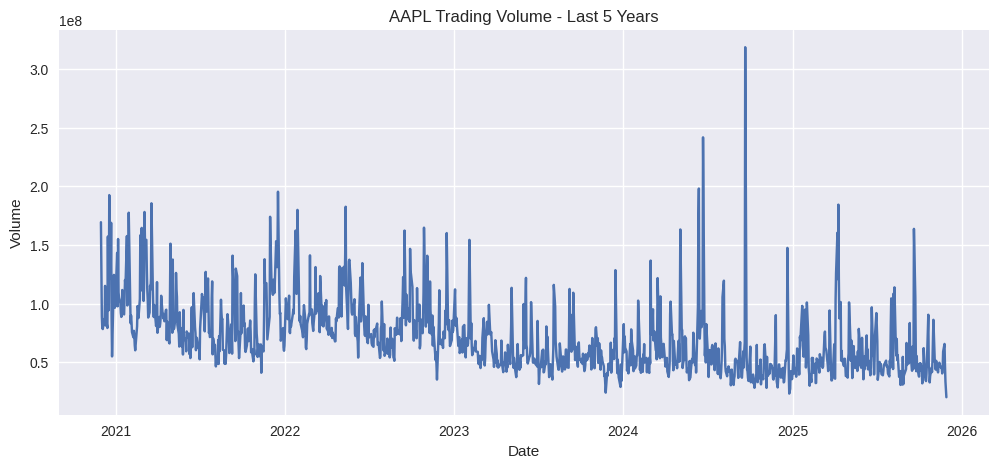

In [17]:
# Volume over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volume'])
plt.title("AAPL Trading Volume - Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

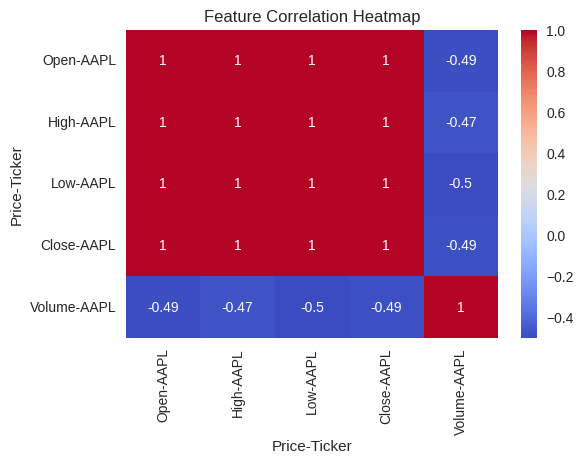

In [18]:
# Correlation heatmap of OHLCV
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [19]:
# Feature engineering (lags + rolling statistics)

# Lag features for closing price
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_lag5'] = df['Close'].shift(5)

# Rolling window features
df['Roll_mean_5']  = df['Close'].rolling(window=5).mean()
df['Roll_mean_10'] = df['Close'].rolling(window=10).mean()
df['Roll_std_5']   = df['Close'].rolling(window=5).std()

# Drop rows with NaN values created by shift/rolling
df = df.dropna().reset_index(drop=True)

print("After feature engineering, shape:", df.shape)

After feature engineering, shape: (1247, 13)


In [20]:
df.head()

Price,Date,Open,High,Low,Close,Volume,Close_lag1,Close_lag2,Close_lag3,Close_lag5,Roll_mean_5,Roll_mean_10,Roll_std_5
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
0,2020-12-11,119.179767,119.501008,117.349679,119.160301,86939800,119.968254,118.547012,121.078003,119.004555,119.843658,119.306318,1.009098
1,2020-12-14,119.345243,120.075332,118.313386,118.547012,79184500,119.160301,119.968254,118.547012,120.464722,119.460117,119.572069,1.076240
2,2020-12-15,121.039040,124.504535,120.834616,124.485062,157243700,118.547012,119.160301,119.968254,121.078003,120.141528,120.074368,2.497202
3,2020-12-16,124.027571,124.962077,123.200131,124.416946,98208600,124.485062,118.547012,119.160301,118.547012,121.315515,120.534811,2.906440
4,2020-12-17,125.478013,126.139968,124.640843,125.283325,94359800,124.416946,124.485062,118.547012,119.968254,122.378529,121.095519,3.242992


In [21]:
feature_cols = [
    'Open', 'High', 'Low', 'Volume',
    'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_lag5',
    'Roll_mean_5', 'Roll_mean_10', 'Roll_std_5'
]

X = df[feature_cols]
y = df['Close']
dates = df['Date']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1247, 11)
y shape: (1247, 1)


In [22]:
# Train–test split (last few months as test)

test_days = 60  # you can change to 90, 120, etc.

split_index = len(df) - test_days

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
dates_train = dates.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]
dates_test = dates.iloc[split_index:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train last date:", dates_train.iloc[-1])
print("Test first date:", dates_test.iloc[0])

Train size: (1187, 11) Test size: (60, 11)
Train last date: 2025-09-04 00:00:00
Test first date: 2025-09-05 00:00:00


In [23]:
# Train Random Forest model and predict on test data

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)          # Train on training data
y_pred_test = rf.predict(X_test)  # Predict only on test part

print("Prediction shape:", y_pred_test.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Prediction shape: (60,)


In [24]:
# Train & Test Error Metrics

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # compatible with all sklearn versions
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Predictions on train and test
y_pred_train = rf.predict(X_train)
y_pred_test  = rf.predict(X_test)

# Calculate metrics
train_mae, train_rmse, train_r2 = regression_metrics(y_train, y_pred_train)
test_mae,  test_rmse,  test_r2  = regression_metrics(y_test,  y_pred_test)

In [25]:
print("===== RANDOM FOREST PERFORMANCE =====")
print(f"Train MAE : {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²  : {train_r2:.4f}")
print("-------------------------------------")
print(f"Test MAE  : {test_mae:.4f}")
print(f"Test RMSE : {test_rmse:.4f}")
print(f"Test R²   : {test_r2:.4f}")

# Put in a DataFrame for nice display (optional)
metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MAE":  [train_mae, test_mae],
    "RMSE": [train_rmse, test_rmse],
    "R2":   [train_r2,  test_r2]
})

print("\nMetrics Summary:")
print(metrics_df)

===== RANDOM FOREST PERFORMANCE =====
Train MAE : 0.4237
Train RMSE: 0.5907
Train R²  : 0.9997
-------------------------------------
Test MAE  : 7.3961
Test RMSE : 10.2896
Test R²   : 0.4095

Metrics Summary:
  Dataset       MAE       RMSE        R2
0   Train  0.423700   0.590744  0.999709
1    Test  7.396104  10.289601  0.409479


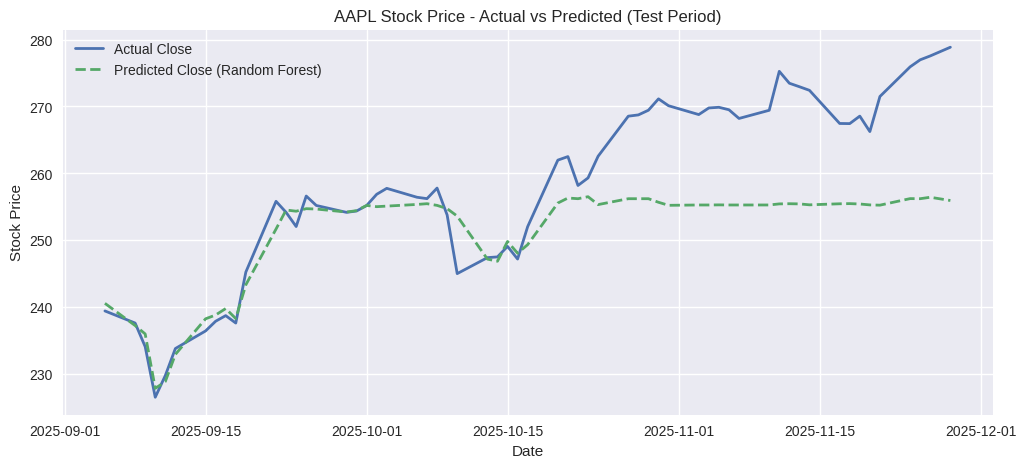

In [27]:
plt.figure(figsize=(12, 5))

plt.plot(dates_test, y_test.values,
         label='Actual Close', linewidth=2)

plt.plot(dates_test, y_pred_test,
         label='Predicted Close (Random Forest)',
         linestyle='--', linewidth=2)

plt.title("AAPL Stock Price - Actual vs Predicted (Test Period)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

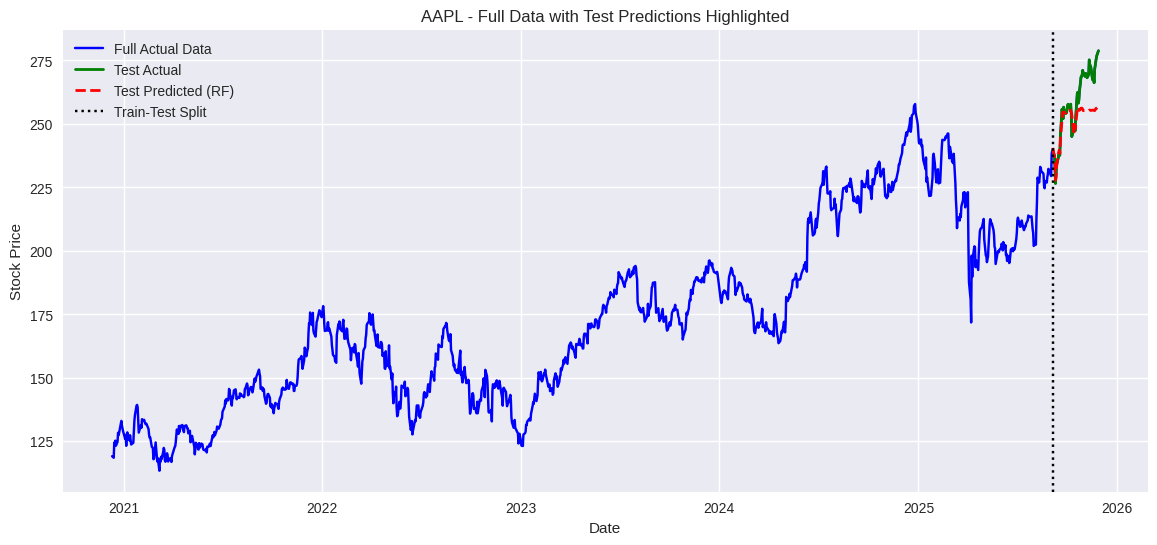

In [28]:
plt.figure(figsize=(14, 6))

# Full actual close prices
plt.plot(dates, y, label="Full Actual Data", color="blue")

# Highlight the test region actual values
plt.plot(dates_test, y_test,
         label="Test Actual", color="green", linewidth=2)

# Predicted values on the test region
plt.plot(dates_test, y_pred_test,
         label="Test Predicted (RF)",
         color="red", linestyle="--", linewidth=2)

# Vertical line where test starts
plt.axvline(dates_test.iloc[0], linestyle=":", color="black", label="Train-Test Split")

plt.title("AAPL - Full Data with Test Predictions Highlighted")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

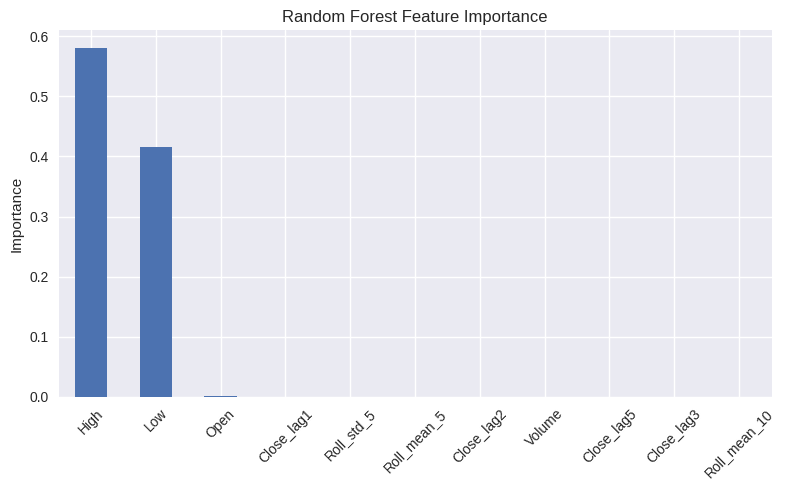

Feature importance values:
High            0.580837
Low             0.416590
Open            0.001537
Close_lag1      0.000389
Roll_std_5      0.000114
Roll_mean_5     0.000106
Close_lag2      0.000104
Volume          0.000103
Close_lag5      0.000082
Close_lag3      0.000073
Roll_mean_10    0.000066
dtype: float64


In [30]:
# Feature importance from Random Forest

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='bar')
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Feature importance values:")
print(feat_imp)